In [1]:
import timm 
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder, CocoDetection
from torchvision.utils import make_grid
import lightning as L
import torch.nn.functional as F
import torchmetrics.functional as tmf

from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from settings import ROOT_DIR


In [2]:
ROOT_DIR = Path(ROOT_DIR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

L.seed_everything(1)
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

Seed set to 1


cuda


In [3]:
resnet = timm.create_model('resnet18', pretrained=True)
resnet.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth',
 'hf_hub_id': 'timm/resnet18.a1_in1k',
 'architecture': 'resnet18',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [80]:
class FolderDataset(L.LightningDataModule):
    def __init__(self, 
                 data_dir: str, 
                 batch_size: int = 32,
                 image_size: int = 224,
                 num_workers = 4):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_workers = num_workers

        norm_mean = (0.485, 0.456, 0.406)
        norm_std  = (0.229, 0.224, 0.225)
        
        self.train_transforms = v2.Compose([
            v2.ToImage(),
            v2.Resize((self.image_size, self.image_size), antialias = True),
            v2.ToDtype(torch.float32, scale = True),
            v2.Normalize(norm_mean, norm_std)
        ])
        
        self.test_transforms = v2.Compose([
            v2.ToImage(),
            v2.Resize((self.image_size, self.image_size), antialias = True),
            v2.ToDtype(torch.float32, scale = True),
            v2.Normalize(norm_mean, norm_std)
        ])
    
    def setup(self, stage = None):
        if stage == 'fit' or stage is None:
            # make training & val sets
            self.train_dataset = ImageFolder(self.data_dir / 'train', transform = self.train_transforms)
            self.val_dataset = ImageFolder(self.data_dir / 'valid', transform = self.test_transforms)
        if stage == 'test' or stage is None:
            self.test_dataset = ImageFolder(self.data_dir / 'test', transform = self.test_transforms)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size = self.batch_size,
                          shuffle = False,
                          num_workers = self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size = self.batch_size,
                          shuffle = False,  
                          num_workers = self.num_workers)

class CocoDataset(L.LightningDataModule):
    def __init__(self,
                 data_dir: str,
                 ann_file: str = '_annotations.coco.json',  
                 batch_size: int = 32,
                 image_size: int = 224,
                 num_workers = 4):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.ann_file = ann_file
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_workers = num_workers
        
        norm_mean = (0.485, 0.456, 0.406)
        norm_std  = (0.229, 0.224, 0.225)
        
        self.train_transforms = v2.Compose([
            v2.ToImage(),
            v2.Resize((self.image_size, self.image_size), antialias = True),
            v2.ToDtype(torch.float32, scale = True),
            v2.Normalize(norm_mean, norm_std)
        ])
        
        self.test_transforms = v2.Compose([
            v2.ToImage(),
            v2.Resize((self.image_size, self.image_size), antialias = True),
            v2.ToDtype(torch.float32, scale = True),
            v2.Normalize(norm_mean, norm_std)
        ])
    
    def setup(self, stage = None):
        train_root = self.data_dir / 'train'
        val_root = self.data_dir / 'valid'
        test_root = self.data_dir / 'test'
        if stage == 'fit' or stage is None:
            self.train_dataset = CocoDetection(root = train_root, 
                                               annFile = train_root / self.ann_file, 
                                               transform = self.train_transforms)
            self.val_dataset   = CocoDetection(root = val_root, 
                                               annFile = val_root / self.ann_file,
                                               transform = self.test_transforms)
        if stage == 'test' or stage is None:
            self.test_dataset  = CocoDetection(root = test_root,  
                                               annFile = test_root / self.ann_file,
                                               transform = self.test_transforms)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size = self.batch_size,
                          shuffle = False,
                          num_workers = self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size = self.batch_size,
                          shuffle = False,  
                          num_workers = self.num_workers)
            
        
        

In [5]:
class TransferClassifier(L.LightningModule):
    def __init__(self, arch = 'resnet18', lr = 1e-3, num_classes = 2):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.model = timm.create_model(arch, pretrained = False, num_classes = self.num_classes)
        self.save_hyperparameters()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr = self.lr)
    
    def training_step(self, batch, idx):
        x, y = batch
        x_hat = self.model(x)
        loss = F.cross_entropy(x_hat, y)
        acc = tmf.accuracy(x_hat, y, task = 'multiclass', num_classes = self.num_classes)
        self.log('train_loss', loss, prog_bar = True, logger = True)
        self.log('train_acc', acc, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, idx):
        x, y = batch
        x_hat = self.model(x)
        loss = F.cross_entropy(x_hat, y)
        acc = tmf.accuracy(x_hat, y, task = 'multiclass', num_classes = self.num_classes)
        self.log('val_loss', loss, prog_bar = True, logger = True)
        self.log('val_acc', acc, prog_bar = True, logger = True)
        return loss

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


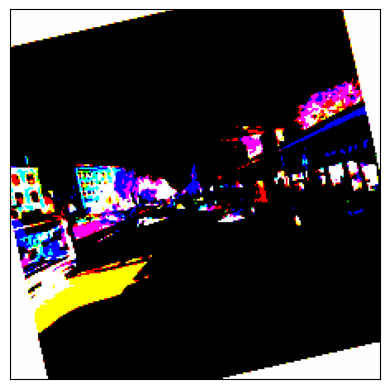

In [81]:
cam_detect = CocoDataset(data_dir = ROOT_DIR / 'data/cams_full')

cam_detect.setup()

from torchvision.utils import draw_bounding_boxes
# torch.Tensor(cam_detect.train_dataset[0][0]).type(torch.uint8)
# plt.imshow(cam_detect.train_dataset[4][0].permute(1, 2, 0))
torch.Tensor([cam_detect.train_dataset[0][1][0]['bbox']])
p = draw_bounding_boxes(cam_detect.train_dataset[0][0].type(torch.uint8), 
                    torch.Tensor([[436, 173, 446, 196]]),
                    colors = 'white')

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = v2.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(p)

In [90]:
model = torchvision.models.get_model('maskrcnn_resnet50_fpn_v2', weights = 'DEFAULT', pretrained = True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [92]:
pred = model(cam_detect.train_dataset[0][0].unsqueeze(0))


TypeError: list indices must be integers or slices, not str

In [96]:
import timm

model = timm.create_model('resnet18', pretrained = True)

trainer = L.Trainer(max_epochs = 3)
trainer.fit(model, cam_detect)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `ResNet`

In [31]:
cam_imgs = FolderDataset('../capstone/data/cams_crop')
# cam_imgs.setup()
# model = timm.create_model('mobilenetv3_large_100', pretrained = True)
# model.eval()
# features = model.forward_features(cam_imgs.train_set[0][0].unsqueeze(0))



In [32]:
model = TransferClassifier()
trainer = L.Trainer(max_epochs = 10, log_every_n_steps = 10)
trainer.fit(model, cam_imgs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


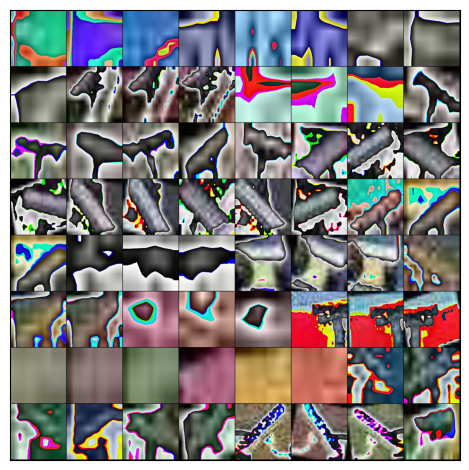

In [29]:
# from torchvision docs
def show_imgs(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols = len(imgs), squeeze = False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])
    plt.tight_layout()
# grid = make_grid(features, nrow = 8)
# show_imgs(grid)
grid = make_grid([cam_imgs.train_set[i][0] for i in range(64)], nrow = 8)
show_imgs(grid)
